In [15]:
def rand_primes(size):
    """
    Generates two random primes of 'size' bits with q < p < 2q.
    """
    while True:
        p = random_prime(1 << (size - 1), 1 << size)
        q = random_prime(1 << (size - 1), 1 << size)
        # Ensure q < p
        if q > p:
            p, q = q, p
        # Ensure q < p < 2q
        if q < p < 2*q:
            return p, q

def generate_vulnerable_rsa_key(bits=256, verbose=True):
    """
    Generates a large, vulnerable RSA key pair, with d < 1/3 n^{1/4}.
    """
    if verbose:
        print(f"--- 1. Generating a Vulnerable {bits}-bit RSA Key ---")

    # Generate large random primes, satisfying q < p < 2q
    p, q = rand_primes(bits // 2)
    n = p * q
    phi_n = (p - 1) * (q - 1)

    # Calculate the maximum d allowed by Wiener's condition: d < (1/3) * n^(1/4)
    max_d = Integer(round(1/3 * n**(1/4)))

    # Choose a small 'd' to ensure the attack succeeds
    d = random_prime(max_d // 100, lbound=1)

    # Calculate the public exponent 'e' using modular inverse
    e = inverse_mod(d, phi_n)
    if verbose:
        print(f"Modulus n bit length: {n.nbits()}")
        print(f"Maximum safe d (for Wiener's attack): {max_d.nbits()} bits")
        print(f"Chosen d: {d} ({d.nbits()} bits)")

    return n, e, d, p, q


In [3]:
def wiener_attack(n, e, return_convergents_count=False, verbose=True):
    """
    Implements Wiener's attack by checking the convergents of e/n.
    If return_convergents_count is True, returns (d, p, q, count), otherwise (d, p, q).
    Set verbose=False to disable print statements.
    """
    if verbose:
        print("\n--- 2. Starting Wiener's Attack ---")

    target_fraction = Rational((e, n))
    cf_expansion = continued_fraction(target_fraction)
    if verbose:
        print(f"Continued Fraction Expansion Coefficients (a_i): {cf_expansion}")

    if verbose:
        print("Testing Convergents...")

    convergents_list = list(cf_expansion.convergents())
    count = 0
    for i, convergent in enumerate(convergents_list):
        k = convergent.numerator()
        d_cand = convergent.denominator()
        if k == 0:
            continue
        count += 1
        if (e * d_cand - 1) % k == 0:
            phi_cand = (e * d_cand - 1) // k
            sum_pq = n - phi_cand + 1
            discriminant = sum_pq^2 - 4 * n
            if discriminant >= 0 and isqrt(discriminant)^2 == discriminant:
                sqrt_discriminant = isqrt(discriminant)
                p_cand = (sum_pq + sqrt_discriminant) // 2
                q_cand = (sum_pq - sqrt_discriminant) // 2
                if p_cand * q_cand == n and p_cand > 1 and q_cand > 1:
                    if verbose:
                        print(f"\n[SUCCESS] Key found at convergent #{i+1}")
                        print(f"Candidate d: {d_cand}")
                        print(f"Candidate p: {p_cand}")
                        print(f"Candidate q: {q_cand}")
                    if return_convergents_count:
                        return d_cand, p_cand, q_cand, count
                    return d_cand, p_cand, q_cand
    if verbose:
        print("\n[FAILURE] Attack failed to find the key within the convergents.")
    if return_convergents_count:
        return None, None, None, count
    return None, None, None


In [4]:
# 1. Generate the vulnerable key
n, e, d_true, p_true, q_true = generate_vulnerable_rsa_key(bits=512)

# 2. Run the attack
d_found, p_found, q_found = wiener_attack(n, e)

# 3. Verification
print("\n--- 3. Verification ---")
if d_found is not None:
    print(f"True d: {d_true}")
    print(f"Found d: {d_found}")
    print(f"Match: {d_true == d_found}")
    
    # Sanity check on factorization
    print(f"True factors: ({p_true}, {q_true})")
    print(f"Found factors: ({p_found}, {q_found})")
    print(f"Factors Match: {(p_true == p_found and q_true == q_found) or (p_true == q_found and q_true == p_found)}")
    
    # --- NEW CRYPTOGRAPHIC CHECK ---
    phi_found = (p_found - 1) * (q_found - 1)
    e_inverse = inverse_mod(e, phi_found)
    print(f"\n[CRYPTOGRAPHIC CHECK]")
    print(f"Inverse of e mod phi: {e_inverse}")
    print(f"d_found matches inverse: {d_found == e_inverse}")

else:
    print("Attack failed or a bug occurred in the implementation logic.")

--- 1. Generating a Vulnerable 512-bit RSA Key ---
Modulus n bit length: 508
Maximum safe d (for Wiener's attack): 126 bits
Chosen d: 326715545499139660170943129728708611 (118 bits)

--- 2. Starting Wiener's Attack ---
Continued Fraction Expansion Coefficients (a_i): [0; 1, 11, 18, 1, 4, 29, 2, 10, 1, 2, 4, 3, 1, 1, 1, 4, 1, 7, 2, 4, 2, 1, 7, 5, 3, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 31, 1, 1, 4, 3, 1, 2, 6, 1, 6, 1, 6, 5, 4, 2, 1, 1, 9, 166, 12, 2, 87, 1, 77, 4, 1, 2, 2, 2, 9, 128633, 3, 2, 2, 4, 7, 1, 8, 1, 2, 1, 17, 12, 2, 1, 5, 4, 13, 2, 12, 1, 12, 3, 3, 5, 4, 6, 1, 1, 1, 2, 1, 2, 3, 3, 1, 3, 64, 2, 8, 2, 4, 2, 1, 16, 2, 3, 2, 1, 15, 5, 6, 2, 1, 6, 5, 1, 4, 3, 1, 2, 1, 12, 2, 3, 2, 2, 1, 1, 1, 1, 1, 17, 2, 49, 1, 9, 1, 2, 3, 1, 2, 11, 1, 7, 36, 2, 2, 20, 2, 2, 1, 3, 2, 1, 2, 1, 1, 5, 1, 7, 11, 1, 4, 5, 1, 16, 1, 1, 3, 1, 9, 1, 8, 3, 2, 5, 4, 1, 5, 1, 10, 2, 1, 2, 2, 6, 3, 5, 1, 10, 1, 14, 1, 6, 4, 73, 1, 1, 1, 2, 1, 2, 1, 1, 1, 4, 2, 1, 3, 4, 22, 1, 1, 1, 5, 1, 2, 5, 2, 1, 12, 1, 7, 1, 

In [16]:
import time
import numpy as np

def run_experiments(bit_sizes, trials_per_size=50):
    """
    Performs experimental runs of Wiener's attack for various RSA bit lengths,
    collecting statistics: mean, std, min, max for both convergents and execution time.
    """
    results = []
    total = int(len(bit_sizes) * trials_per_size)
    completed = 0
    for bits in bit_sizes:
        convergents_list = []
        times = []
        print(f"\n[+] Running experiments for bit-length: {int(bits)}")
        for trial_idx in range(1, int(trials_per_size) + 1):
            n, e, d, p, q = generate_vulnerable_rsa_key(bits, verbose=False)
            start = time.time()
            found_d, found_p, found_q, num_convergents = wiener_attack(n, e, return_convergents_count=True, verbose=False)
            elapsed = time.time() - start
            times.append(elapsed)
            convergents_list.append(num_convergents)
            completed += 1
            percent = (completed / total) * 100
            print(f"    Trial {trial_idx}/{int(trials_per_size)} "
                  f"(Global: {completed}/{total}, {float(percent):.1f}%)", end="\r")
        # Convert lists to numpy arrays for statistics
        times_np = np.array(times)
        conv_np = np.array(convergents_list)
        results.append((
            int(bits),
            float(conv_np.mean()), float(conv_np.std()), int(conv_np.min()), int(conv_np.max()),
            float(times_np.mean()), float(times_np.std()), float(times_np.min()), float(times_np.max())
        ))
        print(f"\n    [✓] Done for {int(bits)} bits. "
              f"Avg. convergents: {conv_np.mean():.2f}, "
              f"std: {conv_np.std():.2f}, min/max: {conv_np.min()}/{conv_np.max()} | "
              f"Avg. time: {times_np.mean():.4f}s, std: {times_np.std():.4f}, min/max: {times_np.min():.4f}/{times_np.max():.4f}")
    print("\n[+] All experiments complete!\n")
    return results


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def show_results(experiment_results):
    """
    Visualizes experiment results with full statistics, table and plots.
    """
    df = pd.DataFrame(
        experiment_results, 
        columns=[
            "Bit-Length n", 
            "Avg. Convergents", "Std Convergents", "Min Convergents", "Max Convergents",
            "Avg. Time (s)", "Std Time (s)", "Min Time (s)", "Max Time (s)"
        ]
    )
    print("\n=== Experiment Results Table ===")
    print(df.to_markdown(index=False, tablefmt="github"))

    # Plot: Average, min, max convergents
    plt.figure(figsize=(8, 5))
    plt.plot(df["Bit-Length n"], df["Avg. Convergents"], marker="o", linestyle="--", color="tab:blue", label="Avg.")
    plt.fill_between(df["Bit-Length n"], df["Min Convergents"], df["Max Convergents"], color="tab:blue", alpha=0.12, label="Min-Max range")
    plt.title("Convergents Statistics vs Bit-Length")
    plt.xlabel("RSA Key Bit-Length (n)")
    plt.ylabel("Convergents Tested")
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot: Average, min, max execution time
    plt.figure(figsize=(8, 5))
    plt.plot(df["Bit-Length n"], df["Avg. Time (s)"], marker="o", linestyle="-", color="tab:green", label="Avg.")
    plt.fill_between(df["Bit-Length n"], df["Min Time (s)"], df["Max Time (s)"], color="tab:green", alpha=0.12, label="Min-Max range")
    plt.title("Execution Time Statistics vs Bit-Length")
    plt.xlabel("RSA Key Bit-Length (n)")
    plt.ylabel("Execution Time (seconds)")
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df

In [24]:
bit_sizes = [256, 512, 1024, 2048]
experiment_results = run_experiments(bit_sizes, trials_per_size=500)


[+] Running experiments for bit-length: 256
    Trial 500/500 (Global: 500/2000, 25.0%)
    [✓] Done for 256 bits. Avg. convergents: 32.02, std: 4.39, min/max: 19/45 | Avg. time: 0.0004s, std: 0.0001, min/max: 0.0003/0.0010

[+] Running experiments for bit-length: 512
    Trial 500/500 (Global: 1000/2000, 50.0%)
    [✓] Done for 512 bits. Avg. convergents: 69.07, std: 6.38, min/max: 49/87 | Avg. time: 0.0011s, std: 0.0003, min/max: 0.0008/0.0028

[+] Running experiments for bit-length: 1024
    Trial 500/500 (Global: 1500/2000, 75.0%)
    [✓] Done for 1024 bits. Avg. convergents: 144.38, std: 9.60, min/max: 117/171 | Avg. time: 0.0030s, std: 0.0004, min/max: 0.0023/0.0051

[+] Running experiments for bit-length: 2048
    Trial 500/500 (Global: 2000/2000, 100.0%)
    [✓] Done for 2048 bits. Avg. convergents: 293.36, std: 13.15, min/max: 251/327 | Avg. time: 0.0090s, std: 0.0007, min/max: 0.0078/0.0149

[+] All experiments complete!




=== Experiment Results Table ===
|   Bit-Length n |   Avg. Convergents |   Std Convergents |   Min Convergents |   Max Convergents |   Avg. Time (s) |   Std Time (s) |   Min Time (s) |   Max Time (s) |
|----------------|--------------------|-------------------|-------------------|-------------------|-----------------|----------------|----------------|----------------|
|            256 |             32.016 |           4.38631 |                19 |                45 |     0.000418551 |    8.80235e-05 |    0.00031209  |    0.000983238 |
|            512 |             69.068 |           6.37772 |                49 |                87 |     0.00112967  |    0.000257052 |    0.000823021 |    0.00277257  |
|           1024 |            144.384 |           9.5994  |               117 |               171 |     0.0029675   |    0.000373386 |    0.00232649  |    0.00514746  |
|           2048 |            293.36  |          13.1532  |               251 |               327 |     0.00903521  |    

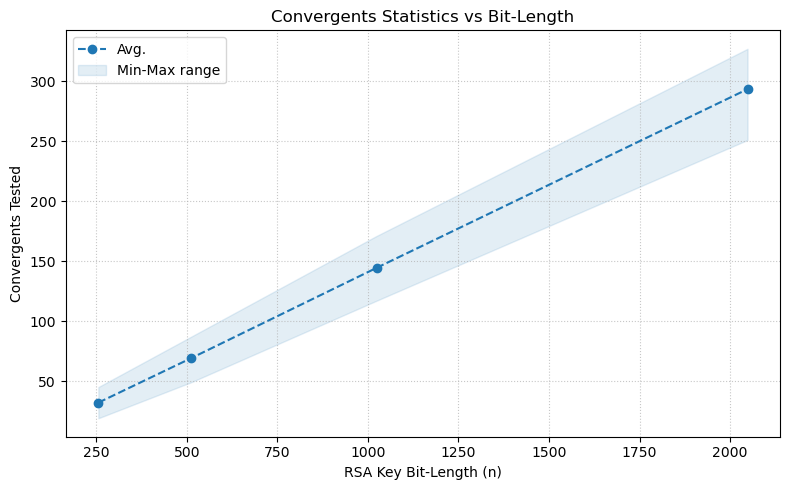

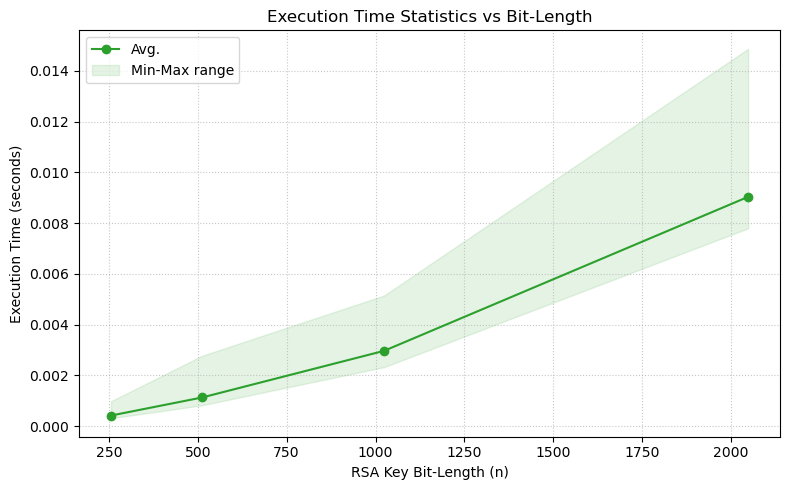

In [25]:
df = show_results(experiment_results)